In [2]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import lognorm


In [3]:
#functions for Abs
def response(dose):
    hill=1.3 #refs?
    IC50=1 #[ug/uL]
    res = 1/(1+(dose/IC50)**-hill)
    return res

def Ab_conc(Ab0,t):
    #avg rates from lynch - rebecca
    
    c1 = Ab0*2000/40; #approximate conversion from mass e.g. 40mg/kg -> ~2000ug/uL
    c2 = 0.4*c1 #fraction of infusion in second decay
    
    r1 = 1.1; r2 = 0.1; #decay rates [1/day]
    
    return c1*np.exp(-r1*t)+c2*np.exp(-r2*t)

def response80(dose,IC80):
    hill=1.3
    IC50 = IC80*4**(1/hill) 
    res = 1/(1+(dose/IC50)**-hill)
    return res




In [4]:
def plot_Ab_details(Ab0,t,c):

    #data from lynch
    lo80=10**-0.9
    hi80=10**1.7

    #dose response curve
    dose=np.logspace(-2,3)
    res = response(dose);
    res80_lo = response80(dose,lo80);
    res80_hi = response80(dose,hi80);

    plt.subplot(131)
    plt.semilogy(t/7,Ab_conc(Ab0,t),color=c)
    plt.xlabel('time (weeks)')
    plt.ylabel('concentration bnAbs ($\mu$g/$\mu$L)')
    plt.ylim([0.1,3e3])

    plt.subplot(132)
    plt.semilogx(dose,res,color='k')
    plt.fill_between(dose,res80_lo,res80_hi,color='gray',alpha=0.1)
    plt.xlabel('dose (Abs per $\mu$L)')
    plt.ylabel('response (proportion inhibited)')

    #inhibition over time
    prop_inhib = response(Ab_conc(Ab0,t))

    prop_inhib_lo = response80(Ab_conc(Ab0,t),lo80);
    prop_inhib_hi = response80(Ab_conc(Ab0,t),hi80);

    plt.subplot(133)
    plt.plot(t/7,prop_inhib,color=c)
    plt.fill_between(t/7,prop_inhib_lo,prop_inhib_hi,color=c,alpha=0.1)
    #plt.fill_between(t/7, prop_inhib, np.ones(len(t)), alpha='0.5',color='gray') #grey fill to 1
    plt.xlabel('time (weeks)')
    plt.ylabel('proportion inhibited')
    plt.ylim([0.5,1])

    plt.tight_layout()

-0.899629454882 1.70385001158


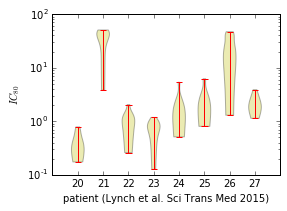

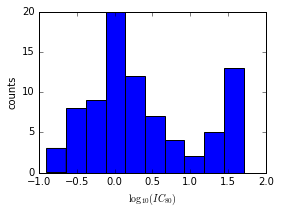

In [15]:
IC80 = np.array([
        [0.174,0.239,0.309,0.287,0.184,0.410,0.539,0.388,0.783,0.648],
        [3.801,13.967,32.949,34.874,37.982,50.565,47.721,38.042,49.204,47.176],
        [2.042,1.238,1.059,1.309,1.087,0.878,0.854,0.442,0.317,0.260],
        [0.685,0.965,1.179,0.801,0.801,0.811,1.006,0.654,0.478,0.286,0.126],
        [5.335,2.536,1.654,1.650,1.721,1.223,0.796,0.662,0.511,0.564],
        [6.206,2.486,2.705,1.551,1.322,1.052,0.803],
        [42.586,40.768,35.319,41.305,46.946,24.380,21.407,18.528,22.946,15.874,12.792,7.985,8.204,3.383,1.297],
        [2.836,3.223,3.876,2.286,2.383,1.978,1.595,1.552,1.134,1.555]])

#between patient variability in IC80
plt.figure(figsize=(4,3),dpi=600)
for i in range(8):
    plt.violinplot(IC80[i],[i])
plt.xticks(range(8),np.arange(8)+20)
plt.yscale('log')    
plt.xlabel('patient (Lynch et al. Sci Trans Med 2015)')
plt.ylabel('$IC_{80}$')
plt.tight_layout()
plt.gcf().savefig('between_patient_IC80.pdf')  # No warning now

plt.figure(figsize=(4,3),dpi=600)
plt.hist(np.log10(np.hstack(IC80)))
plt.xlabel('$\log_{10}(IC_{80})$')
plt.ylabel('counts')
plt.tight_layout()
plt.gcf().savefig('IC80_distribution.pdf')  # No warning now


 

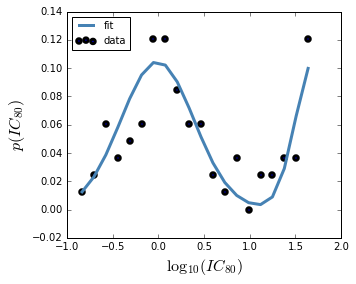

In [101]:
#trying to fit the distribution       
def func1d_pablo(x, nbins):
    histo, bin_edges = np.histogram(x,nbins)
    bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
    #plt.step(bin_center,histo,where='mid')
    return histo,bin_center


nbins=10

p_x,x=func1d_pablo(np.log10(np.hstack(IC80)),20)

#d1=norm.fit(p_x[0:7]/sum(p_x))
#d2=norm.fit(p_x[8:]/sum(p_x))

plt.figure(figsize=(5,4),dpi=600)
    

p1=norm.pdf(x, -0.01, 0.4)
p2=norm.pdf(x, 1.7, 0.2)
p_fit=(2*p1+p2)
p_fit=p_fit/sum(p_fit)

plt.scatter(x,p_x/sum(p_x),lw=3)
plt.plot(x,p_fit,lw=3,color='steelblue')

#plt.plot(x,p1/3)
#plt.plot(x,p2/5)


plt.xlabel('$\log_{10}(IC_{80})$',fontsize=16)
plt.ylabel('$p(IC_{80})$',fontsize=16)
plt.legend(['fit','data'],loc=2,fontsize=10)
plt.tight_layout()


plt.gcf().savefig('fit_dist.pdf')  # No warning now


In [8]:
#updating the rates of events
def update_rates(X,t,Ab0):
    
    prop_inhib = response(Ab_conc(Ab0,t%56)) #modulo 8 weeks
    
    Bt=Bt0*(1-prop_inhib) #ab dependent infectivity
    
    S  = X[0]
    I  = X[1]
    Im = X[2]
    V  = X[3]
    Vm = X[4]
    
    r = np.array([
            aS,               # 0 -> S
            dS*S,             # S -> 0
            S*Bt*V*(1-mu),    # S+V  -> I  
            S*Bt*V*mu,        # S+V  -> I*
            #S*Bt0*Vm*mu,      # S+V* -> I ignore back mutations
            S*Bt0*Vm,         # S+V* -> I*    
            dI*I,             # I -> poisson(pi)*V
            dI*Im,            # I* -> poisson(pi)*V*
            gam*V,            # V -> 0
            gam*Vm            # V* ->0
            ])
            
    return r#updating the rates of events

#keeping track of the transitions as a matrix
def update_transition_mat(x,t):    
    
    pr1 = np.random.poisson(pi);
    pr2 = np.random.poisson(pi/10);
    
                #[S ,I  ,I* ,V  ,V*]
    T=np.array([
                [ 1 ,0  ,0  ,0  ,0  ],
                [-1 ,0  ,0  ,0  ,0  ],
                [-1 ,1  ,0  ,-1 ,0  ],
                [-1 ,0  ,1  ,-1 ,0  ],
                #[-1 ,1  ,0  ,0  ,-1 ],
                [-1 ,0  ,1  ,0  ,-1 ],
                [0  ,-1 ,0  ,pr1,0  ],
                [0  ,0  ,-1 ,0  ,pr2],
                [0  ,0  ,0  ,-1 ,0  ],
                [0  ,0  ,0  ,0  ,-1 ]
                ])
    
    return T

#function that solves stochastically using tau-leap method
def bnabs_tauleap(t,Ab0,inc_time):

    dt=t[1]; x=np.array([aS/dS,0,0,0,0]); y=[] #initialize
    for ti in t:
        
        y.append(x) #the list of states
        
        r = update_rates(x,ti,Ab0) #make new rate vector
        
        E = np.random.poisson(r*dt) #calculate events
        
        dx = np.sum(np.matrix.transpose(update_transition_mat(x,ti))*E,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti==inc_time:
            x[1] = x[1] + 1
 
        x[x<1]=0 #make sure no negative numbers or fractions
        
    return np.array(y)

In [9]:
t=np.linspace(0,2*7,1e4)

dt=t[1]; x=np.array([aS/dS,0,0,0,0]); y=[] #initialize

ti=t[5]
Ab0=0

r = update_rates(x,ti,Ab0) #make new rate vector
        
E = np.random.poisson(r*dt) #calculate events

T= update_transition_mat(x,ti)

NameError: name 'aS' is not defined

In [ ]:
np.dot(np.transpose(T),E)

In [ ]:
#do a single simulation without antibodies

# parameters for viral dynamics model
aS  = 1e8  # constant growth rate of suseceptible cells
dS  = 0.5    # death rate of suseceptible cells
Bt0 = 1e-10   # infection rate of T-cells
dI  = 1      # death rate of infected cells
pi  = 1e4    # burst rate of virus from cells
gam = 23     # virus clearance rate
mu  = 0.01   # fraction that are Ab resistant

R0=pi/gam*Bt0*aS/dS*(1-mu)/dI #calculate basic reproducive number (~8-11 for HIV)
print('Basic reproductive number is', R0)

num_sims=7; 
t=np.linspace(0,2*7,1e4)

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,0,0)
    plt.subplot(211)
    plt.semilogy(t/7,tlp_sol[:,1]+1,alpha=0.6)
    plt.ylabel('Infected cells ($I$)')
    plt.ylim([0.1,1e9])
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,2]+1,alpha=0.6)
    plt.ylim([0.1,1e9])
    plt.ylabel('bnAb resistant \n infected cells ($I*$)')

plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('control_R0-8_6.pdf')  # No warning now


In [ ]:
#2 dose simulation

t=np.linspace(0,16*7,1e3) #2 dose curve

Ab0=10; Rt=(1-response(Ab_conc(Ab0,t%56)))*R0 #R0 over time

num_sims=10; 
trial_inds=np.linspace(0,len(t)-100,num_sims)

plt.figure(figsize=(6,6),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0,t[trial_inds[i]])
    plt.subplot(311)
    plt.plot(t/7,Rt,'k')
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(312)
    plt.semilogy(t/7,tlp_sol[:,1]+1,alpha=0.6)
    plt.ylabel('Infected cells ($I$)')
    plt.ylim([1e-1,1e9])
    plt.subplot(313)
    plt.semilogy(t/7,tlp_sol[:,2]+1,alpha=0.6)
    plt.ylabel('bnAb resistant \n infected cells ($I*$)')
    plt.ylim([1e-1,1e9])
#plt.semilogy(t/7,tlp_sol[:,4]+0.01,alpha=0.6)
#plt.ylim([0.1,1e7])
#plt.xlim([0,t[-1]/7])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_trials_10mg-kg.pdf')  # No warning now


In [ ]:
#show stuff about antibodies

c1='c'; c2='m'
t=np.linspace(0,8*7,1e3) #2 dose curve

#first plot Ab details
plt.figure(figsize=(8,3),dpi=600)
plot_Ab_details(30,t,c1)
plot_Ab_details(10,t,c2)
plt.legend(['30mg/kg','10mg/kg'],loc=0,fontsize=10)
plt.gcf().savefig('Ab_details.pdf')  # No warning now

#plot the theoretical treatment plan
plt.figure(figsize=(4,4),dpi=600)
plt.subplot(211)
plt.semilogy(t/7,Ab_conc(10,t),color=c2)
plt.semilogy(t/7,Ab_conc(30,t),color=c1)

plt.ylabel('Abs ($\mu$g/$\mu$L)')
plt.subplot(212)
Rt10=(1-response(Ab_conc(10,t)))*R0
Rt30=(1-response(Ab_conc(30,t)))*R0

plt.plot(t/7,Rt10,color=c1)
#plt.fill_between(t/7,Rt10,np.ones(len(t)),color=c1, alpha='0.5')
plt.plot(t/7,Rt30,color=c2)
plt.plot(t/7,np.ones(len(t)),color='k',lw=3)
#plt.fill_between(t/7,Rt30,np.ones(len(t)),color=c2, alpha='0.5')

plt.xlabel('time (weeks)')
plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
plt.legend(['10mg/kg','30mg/kg'],loc=0,fontsize=10)
plt.tight_layout()
plt.gcf().savefig('Ab1dose.pdf')  # No warning now



In [ ]:
#run each simulation num times

trial_days = 80*7

t_trial=np.linspace(0,trial_days,5e3) #80 week trial

trial_names=['msm10','msm30','msmc','w10','w30','wc']
inc_rate = [3.,3.,3.,5.,5.,5.] #percent incidence per year
size=[800,800,800,500,500,500]
Ab0_list=[10,30,0,10,30,0]
clist=[c1,c2,'k',c1,c2,'k']

In [ ]:
#actually simulate the trials
trial_data=[]; incidences=[]
for trial in range(len(trial_names)):
    
    Ab0=Ab0_list[trial] #Ab infusions for trial

    #get rare events!
    avg_inc = inc_rate[trial]/100/365*t_trial[-1] #the average over whole trial
    inc_list = np.random.poisson(avg_inc,size[trial]) #list of incidences
    real_inc = inc_list[inc_list>0] #list where incidence>0

    print('there were '
          + str(len(real_inc))
          + ' individuals with '
          + str(np.sum(real_inc)) 
          + ' incidences in trial '
          + trial_names[trial])
    
    incidences.append(len(real_inc))
    
    #only loop over real incidences
    tlp_all_sol=[]
    for i in range(len(real_inc)):
        
        incx = np.round(np.random.random_sample((real_inc[i],))*len(t_trial)) #get n random indices for each person with n incidences

        sol=0
        for i in range(len(incx)):
            inc_time = t_trial[int(incx[i])] #get each incidence time
            sol=sol+bnabs_tauleap(t_trial,Ab0,inc_time) #add each incidence?
        
        tlp_all_sol.append(sol)

    trial_data.append(tlp_all_sol)
    

In [ ]:
#plot trial results

cols=7
for k in range(len(trial_names)):
    
    num = incidences[k]
    
    rows = int(np.ceil(num/cols))

    f, axarr = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(10,8),dpi=600)
    
    for j in range(num):
        ax=axarr[j%rows][j%cols]
        ax.plot(t_trial/7,np.log10(trial_data[k][j][:,1]),color=clist[k],lw=3) #I
        ax.plot(t_trial/7,np.log10(trial_data[k][j][:,2]),color=clist[k],lw=1,linestyle='-.') #I*
        ax.tick_params(axis='both', which='major', labelsize=8)
            
    #plt.xticks(range(0,80,16),range(0,10,2))
    plt.ylim([-1,9])
  
    plt.tight_layout()
    plt.gcf().savefig(trial_names[k]+'.pdf')  # No warning now
    